# Fetal Brain Segemnation In Ultrasound Scan Using PyTorch

In this colab note book we will create and train a UNet based Fetal Brain Segmentation segmentation model in PyTorch and save the model for future inference.
Please note that you need to download saved model as it will be deleted after your colab session expires.

Key steps envolved in creating and training the model are
<h2>Envionment Setup</h2>
<ul>
<li> Setup colab GPU environment </li>
<li> Install of required packacges. </li>
<li> Clone my Github for datasets and Unzip dataset file, alternativly you can use your own dataset with some modifications of path etc. </li>
<li>Append system path to include the temperary folder. </li>
<li> Develop helper method to show images.</li>
</ul>
<h2> Core Network Developement and Testing.</h2>
<ul>
<li>Set network configuration parameters.</li>
<li>Read CSV file for paths of Images and associated Ground Truth. </li>
<li>Split data into test and validation set.</li>
<li>Split data into test and validation set.</li>
<li>Define data augmentation functions.</li>
<li>Create a custom dataset with data augmentation.</li>
<li>Load dataset into batches with PyTorch data loader.</li>
<li>Create segmentation model.</li>
<li>Create training and validation function.</li>
<li>Train and save the model.</li>
<li>Inference.</li>
</ul>


##Envionment Setup

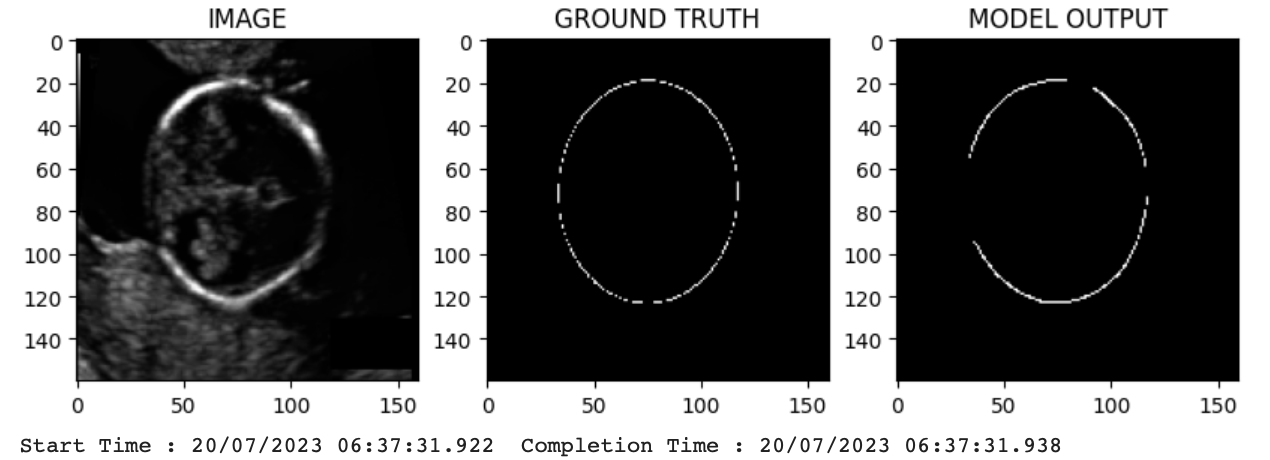

### Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=7306ac9bdd5fda13a4f1eebe305bb11a8cab72bdd4c80a5cba3b40b2c0f4d64a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=33647d8f6ca70fc6a28c6cf58df34965203b1c2129c1b1a86052566c1b31ed73
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumenta

### Append system path and import packages

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
import sys
PROJECT_DIR='/gdrive/MyDrive/fetal/'
DATA_DIR='/gdrive/MyDrive/fetal/'
sys.path.append(DATA_DIR)

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

### Helper function to show images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')




## Core Network Development and Training

 ### Set network configuration parameters

In [ ]:

DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')
EPOCHS = 30
LR= 0.009
IMAGE_SIZE=128
BATCH_SIZE=16
ENCODER ='timm-efficientnet-b0'
WEIGHTS='imagenet'


### Read paths of Images and associated Ground Truth

In [ ]:
from torchdata.datapipes.iter import FileLister
import pandas as pd
train_dir=DATA_DIR +'training_set/'
dp = FileLister(root=train_dir, recursive=False)
image_files=mask_file=dp.filter(lambda fname: fname.endswith('_HC.png'))
mask_files=dp.filter(lambda fname: fname.endswith('_HC_Annotation.png'))
image_list=list(image_files)
mask_list=list(mask_files)
#print(len(image_list))
df = df = pd.DataFrame(list(zip(image_list, mask_list)),
               columns =['images', 'masks'])

df.head()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/utils/common.py:149: UserWarning: Lambda function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


,images,masks
0,/gdrive/MyDrive/fetal/training_set/101_HC.png,/gdrive/MyDrive/fetal/training_set/101_HC_Anno...
1,/gdrive/MyDrive/fetal/training_set/103_HC.png,/gdrive/MyDrive/fetal/training_set/103_HC_Anno...
2,/gdrive/MyDrive/fetal/training_set/104_HC.png,/gdrive/MyDrive/fetal/training_set/104_HC_Anno...
3,/gdrive/MyDrive/fetal/training_set/105_HC.png,/gdrive/MyDrive/fetal/training_set/105_HC_Anno...
4,/gdrive/MyDrive/fetal/training_set/106_HC.png,/gdrive/MyDrive/fetal/training_set/106_HC_Anno...


In [ ]:
index=2
row = df.iloc[index]
image_path=row.images
mask_path = row.masks

image= cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE) # convert BGR image read by cv2 to RGB
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0
print(f'Image Path : {image_path}  \nMask Path : {mask_path}')


Image Path : /gdrive/MyDrive/fetal/training_set/104_HC.png  
Mask Path : /gdrive/MyDrive/fetal/training_set/104_HC_Annotation.png


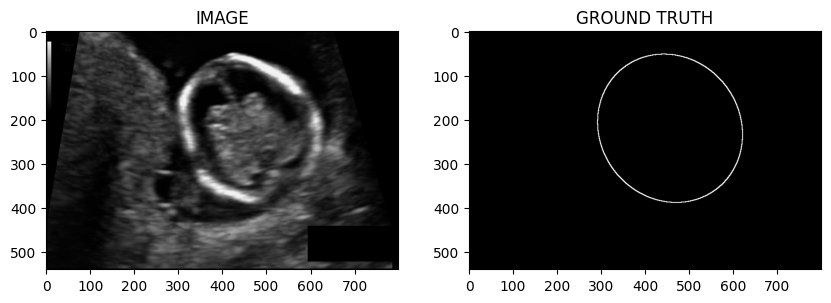

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image, cmap = 'gray')

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

### Split data into test and validation set

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2)

### Define data augmentation functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True,),
                   A.HorizontalFlip(p=0.5),
                   A.VerticalFlip(p=0.5),],is_check_shapes=False) # is_check_shapes=False
def get_val_augs():
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True,),],is_check_shapes=False) #is_check_shapes=False

### Create custom dataset with data augmentation

In [ ]:
from torch.utils.data import Dataset


In [ ]:
class FetalBrainSegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = df.iloc[index]
    image_path = row.images
    mask_path = row.masks

    image= cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert BGR image read by cv2 to RGB
    image = np.expand_dims(image, axis=-1)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    #mask is in [ h, w] form add channel to it [h, w,c]
    mask = np.expand_dims(mask, axis=-1)

    # Apply albumentations is applicable
    if self.augmentations:
      data=self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    # convert  image and mask from [h,w,c]--> [c,h,w]
    image= np.transpose(image,(2,0,1))
    mask= np.transpose(mask,(2,0,1))

    # convert them to torch tensor and normalise

    image = torch.Tensor(image)/255.0
    mask = torch.Tensor(mask)/255.0

    return image, mask




In [ ]:
trainset = FetalBrainSegmentationDataset(train_df, get_train_augs())
validset = FetalBrainSegmentationDataset(val_df, get_val_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 623
Size of Validset : 156


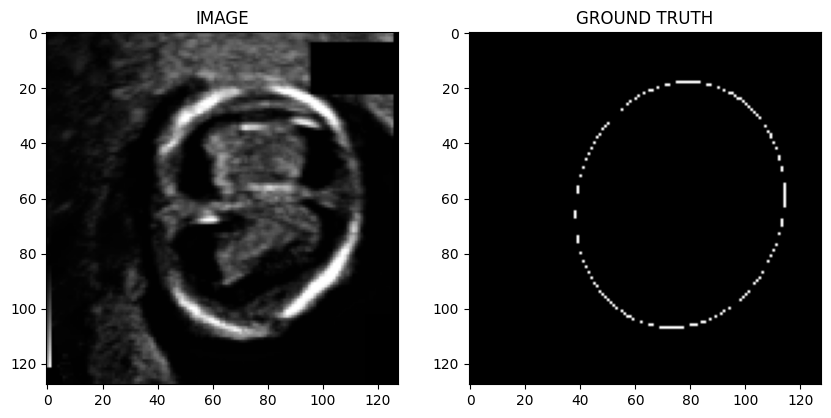

In [ ]:
idx=21
image, mask=trainset[idx]
show_image(image,mask)

### Load dataset into batches with pytorch dataloader

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader =  DataLoader(validset,batch_size=BATCH_SIZE,)

#trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,generator=torch.Generator(device='cuda'))
#validloader =  DataLoader(validset,batch_size=BATCH_SIZE,generator=torch.Generator(device='cuda'))

In [ ]:
print(f'Total number of batches in train loader : {len(trainloader)}')
print(f'Total number of batches in Valid loader : {len(validloader)}')

Total number of batches in train loader : 39
Total number of batches in Valid loader : 10


In [ ]:
for image, mask in trainloader:
  break
print(f' One batch image shape {image.shape}')
print(f' One batch mask shape {mask.shape}')


 One batch image shape torch.Size([16, 1, 128, 128])
 One batch mask shape torch.Size([16, 1, 128, 128])


### Create segmentation model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class FetalBrainSegmentationModel(nn.Module):
  def __init__(self):
    super(FetalBrainSegmentationModel, self).__init__()
    self.arc = smp.Unet(encoder_name=ENCODER,
                        encoder_weights=WEIGHTS,
                        in_channels=1,
                        classes=1,
                        activation=None,
                        )
  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks!=None:
      loss1=DiceLoss(mode='binary')(logits, masks)
      loss2= nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits


In [ ]:
model=FetalBrainSegmentationModel()
model.to(DEVICE)

FetalBrainSegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
 

### Create training and validation function

In [ ]:
def train_net(dataloader, model, optimizer):
  model.train()
  total_loss = 0.0
  for images, masks in tqdm(dataloader):
    images =images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits , loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss +=loss.item()
  return total_loss/len(dataloader)

In [ ]:
def eval_net(dataloader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images =images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits , loss = model(images, masks)
      total_loss +=loss.item()
  return total_loss/len(dataloader)

###Train and save model

In [ ]:
optimizer=torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss=np.Inf
for i in range (EPOCHS):
  train_loss=train_net(trainloader, model, optimizer)
  valid_loss= eval_net(validloader, model)
  if valid_loss <best_valid_loss:
    torch.save(model.state_dict(), PROJECT_DIR+'fetal_brain_best_model_v0.pt')
    print("Model saved")
    best_valid_loss=valid_loss
  print(f'ECPOCH : {i+1} Training Loss : {train_loss}, Validation Loss : {valid_loss}')


100%|██████████| 10/10 [00:02<00:00,  3.53it/s]


Model saved
ECPOCH : 1 Training Loss : 0.9576265460405594, Validation Loss : 0.9722276151180267


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


Model saved
ECPOCH : 2 Training Loss : 0.8757299582163492, Validation Loss : 0.961495178937912


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Model saved
ECPOCH : 3 Training Loss : 0.8584701311893952, Validation Loss : 0.9273190140724182


100%|██████████| 10/10 [00:02<00:00,  3.49it/s]


Model saved
ECPOCH : 4 Training Loss : 0.8451694066707904, Validation Loss : 0.8777263343334198


100%|██████████| 10/10 [00:02<00:00,  3.34it/s]


ECPOCH : 5 Training Loss : 0.8384427733910389, Validation Loss : 0.8791673660278321


100%|██████████| 10/10 [00:03<00:00,  3.11it/s]


Model saved
ECPOCH : 6 Training Loss : 0.8367820596083616, Validation Loss : 0.8710791349411011


100%|██████████| 10/10 [00:02<00:00,  3.47it/s]


Model saved
ECPOCH : 7 Training Loss : 0.8347698083290687, Validation Loss : 0.8488057792186737


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


Model saved
ECPOCH : 8 Training Loss : 0.8266730675330529, Validation Loss : 0.841196608543396


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


ECPOCH : 9 Training Loss : 0.8198908491012378, Validation Loss : 0.883702528476715


100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


ECPOCH : 10 Training Loss : 0.8164429634045332, Validation Loss : 0.8680424630641937


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


ECPOCH : 11 Training Loss : 0.8166487568464035, Validation Loss : 0.8470695555210114


100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


ECPOCH : 12 Training Loss : 0.8093136717111636, Validation Loss : 0.8461042582988739


100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


Model saved
ECPOCH : 13 Training Loss : 0.8154061818734194, Validation Loss : 0.8390404403209686


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Model saved
ECPOCH : 14 Training Loss : 0.8019973788505945, Validation Loss : 0.824070930480957


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


Model saved
ECPOCH : 15 Training Loss : 0.8028202759913909, Validation Loss : 0.813713425397873


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


ECPOCH : 16 Training Loss : 0.7995042357689295, Validation Loss : 0.8218727350234986


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]


ECPOCH : 17 Training Loss : 0.7962720745649093, Validation Loss : 0.8193696737289429


100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


ECPOCH : 18 Training Loss : 0.7902108002931644, Validation Loss : 0.8165722846984863


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]


ECPOCH : 19 Training Loss : 0.7923199840081043, Validation Loss : 0.8161477744579315


100%|██████████| 10/10 [00:02<00:00,  3.75it/s]


ECPOCH : 20 Training Loss : 0.7886582582424848, Validation Loss : 0.8168730735778809


100%|██████████| 10/10 [00:02<00:00,  3.73it/s]


ECPOCH : 21 Training Loss : 0.7866870577518756, Validation Loss : 0.8386944890022278


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


ECPOCH : 22 Training Loss : 0.788396132298005, Validation Loss : 0.8207835018634796


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]


ECPOCH : 23 Training Loss : 0.7814981157963092, Validation Loss : 0.8188496410846711


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]


Model saved
ECPOCH : 24 Training Loss : 0.7841082811355591, Validation Loss : 0.8103910982608795


100%|██████████| 10/10 [00:03<00:00,  3.31it/s]


Model saved
ECPOCH : 25 Training Loss : 0.7740750037706815, Validation Loss : 0.8034116148948669


100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


Model saved
ECPOCH : 26 Training Loss : 0.7744872279656239, Validation Loss : 0.8026171505451203


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]


Model saved
ECPOCH : 27 Training Loss : 0.7723004970795069, Validation Loss : 0.7929081320762634


100%|██████████| 10/10 [00:02<00:00,  3.36it/s]


Model saved
ECPOCH : 28 Training Loss : 0.769719619017381, Validation Loss : 0.789999908208847


100%|██████████| 10/10 [00:02<00:00,  3.74it/s]


ECPOCH : 29 Training Loss : 0.7752274015010931, Validation Loss : 0.796077436208725


100%|██████████| 10/10 [00:02<00:00,  3.71it/s]

ECPOCH : 30 Training Loss : 0.7601448755997878, Validation Loss : 0.795406574010849


###Inference

 Start Time : 20/07/2023 06:37:31.113  Completion Time : 20/07/2023 06:37:31.127



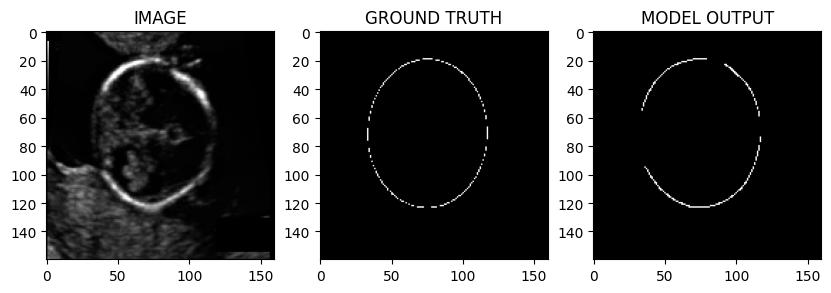

 Start Time : 20/07/2023 06:37:31.922  Completion Time : 20/07/2023 06:37:31.938



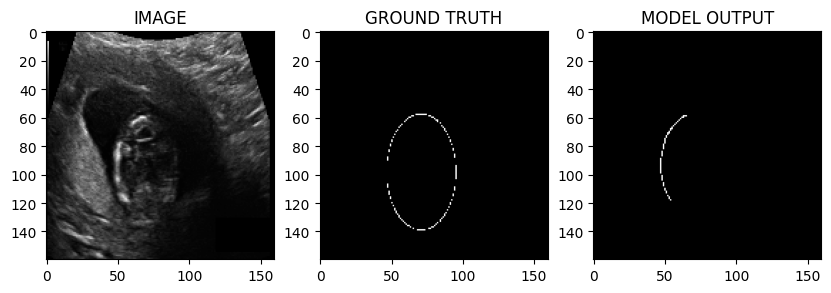

 Start Time : 20/07/2023 06:37:32.504  Completion Time : 20/07/2023 06:37:32.524



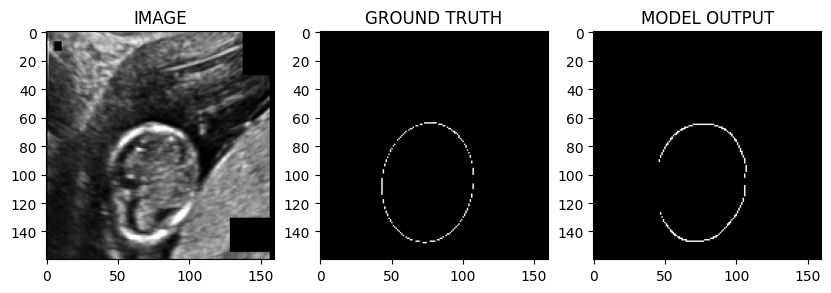

 Start Time : 20/07/2023 06:37:33.089  Completion Time : 20/07/2023 06:37:33.109



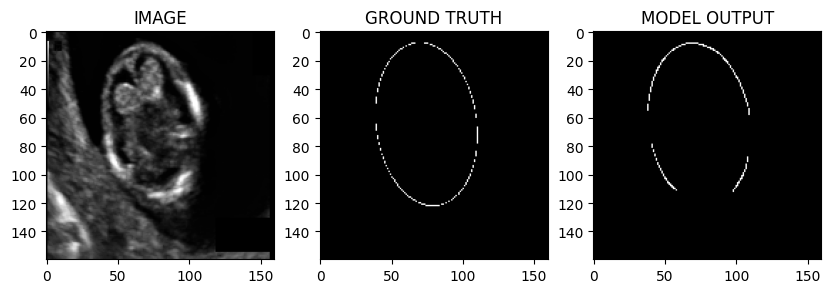

 Start Time : 20/07/2023 06:37:33.716  Completion Time : 20/07/2023 06:37:33.734



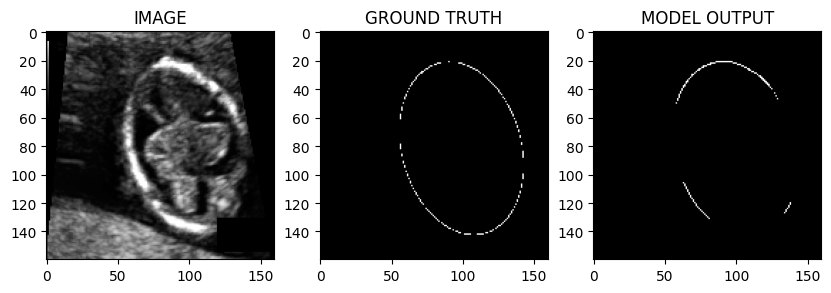

In [ ]:
from datetime import datetime
model.load_state_dict(torch.load(PROJECT_DIR+'fetal_brain_best_model_v0.pt'))

for index in range (5,10):
  image, mask = validset[index]
  start_time = datetime.now()
  logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (c, h, w) ---> (1, C, H,W) , 1 for batch
  pred_mask= torch.sigmoid(logits_mask)  # as we have not used sigmoid in pred function
  pred_mask = (pred_mask>0.5)*1.0   # convert any pixel less greater than .5 to 1
  end_time = datetime.now()
  show_image(image, mask, pred_mask.detach().cpu().squeeze(0)) # detach and remove batch info added earlier
  print(f' Start Time : {start_time.strftime("%d/%m/%Y %H:%M:%S.%f")[:-3]}  Completion Time : {end_time.strftime("%d/%m/%Y %H:%M:%S.%f")[:-3]}\n')
  plt.show()

## Regression Head

In [ ]:
class FetalBrainRegressionModel(nn.Module):
  def __init__(self):
    super(FetalBrainRegressionModel, self).__init__()
    self.arc = smp.Unet(encoder_name=ENCODER,
                        encoder_weights=WEIGHTS,
                        in_channels=1,
                        classes=1,
                        activation=None,
                        )
  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks!=None:
      loss1=DiceLoss(mode='binary')(logits, masks)
      loss2= nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits